<a href="https://colab.research.google.com/github/danarfthr/pengolahan-citra-digital/blob/main/workshop_2/HOG_face_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Object Detection
## Pengolahan Citra Digital

Danar Fathurahman

24/538200/PA/22828

# Import Library

In [10]:
!pip install wget
import wget
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset

In [11]:
wget.download("https://drive.google.com/uc?export=download&id=1IMCE-y6zrE8j4ZE-JwlElN5bhQ8xf_Kf", "dataset.zip")

'dataset.zip'

In [12]:
zip_path = "dataset.zip"
extract_to = "./"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Selesai extract ke:", extract_to)

Selesai extract ke: ./


In [13]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        return None, None

    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image, gray

# Feature Extraction

In [14]:
from skimage.feature import hog

# HOG / image params
ORIENTATIONS = 9
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)

def extract_hog_features(image_gray):
    """
    Ekstrak fitur HOG dari gambar grayscale (sudah di-resize).
    Output: vektor HOG.
    """
    features, hog_maps = hog(
        image_gray,
        orientations=ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )
    return features, hog_maps

# Pre-processing Dataset

In [15]:
def crop_half_image(img, bottom=True):
    """
    Mengembalikan crop separuh bawah (bottom=True) atau separuh atas (bottom=False)
    img: grayscale atau BGR numpy array
    """
    h = img.shape[0]
    mid = h // 2
    if bottom:
        cropped = img[mid:, :]
    else:
        cropped = img[:mid, :]
    return cropped

In [16]:
dataset_dir = './dataset/'
IMAGE_SIZE = (64,64)
X = []
y = []
hog_img =[]

for root, dirs, files in os.walk(dataset_dir):
    print(root, dirs, files)
    for f in files:
        # Skip non-image files like .DS_Store
        if not f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            continue
        _, image_gray = load_image(os.path.join(root, f))
        if image_gray is None:
            print(f"[WARN] Gagal memuat gambar: {f}")
            continue
        img_crop = crop_half_image(image_gray, bottom=True)
        # jika crop menghasilkan area kosong atau sangat kecil, fallback ke citra penuh
        if img_crop is None or img_crop.size == 0 or img_crop.shape[0] < 4 or img_crop.shape[1] < 4:
            img_crop = image_gray  # fallback
            # optional: print warning
            print(f"[WARN] Crop menghasilkan area kecil untuk {f}, menggunakan citra penuh.")

        roi_resized = cv2.resize(img_crop, IMAGE_SIZE, interpolation=cv2.INTER_AREA) # type: ignore
        hog_feature, hog_maps = extract_hog_features(roi_resized)
        if hog_feature is None:
            continue

        hog_img.append(hog_maps)
        X.append(hog_feature)

        if root.split('/')[-1]=="without_mask":
            y.append(0)

        else:
            y.append(1)

X = np.array(X)
y = np.array(y)

if X.size > 0:
    print(f"[INFO] Total sampel fitur: {X.shape[0]}, dimensi fitur: {X.shape[1]}")
else:
    print("[WARN] Tidak ada fitur yang berhasil diekstrak!")

./dataset/ ['without_mask', 'with_mask'] []
./dataset/without_mask [] ['0_0_dongchengpeng_0020.jpg', '0_0_caiyilin_0051.jpg', '0_0_chenhuilin_0018.jpg', '0_0_caiyilin_0024.jpg', '0_0_dongchengpeng_0001.jpg', '0_0_chenxuedong_0050.jpg', '0_0_anhu_0211.jpg', '0_0_anhu_0027.jpg', '0_0_jianailiang_0015.jpg', '0_0_guanyue_0083.jpg', '0_0_dongchengpeng_0042.jpg', '0_0_huangjinglun_0010.jpg', '0_0_fanyichen_0081.jpg', '0_0_caiyilin_0029.jpg', '0_0_chenhuilin_0096.jpg', '0_0_hanxue_0088.jpg', '0_0_fanyichen_0078.jpg', '0_0_hanxue_0010.jpg', '0_0_aidai_0074.jpg', '0_0_chenyao_0074.jpg', '0_0_huangjinglun_0008.jpg', '0_0_gulinazha_0082.jpg', '0_0_anhu_0098.jpg', '0_0_chenglong_0036.jpg', '0_0_huge_0029.jpg', '0_0_aidai_0043.jpg', '0_0_guanyue_0011.jpg', '0_0_caizhuoyan_0013.jpg', '0_0_chenyao_0016.jpg', '0_0_fanshiqi_0089.jpg', '0_0_baobeier_0140.jpg', '0_0_fanyichen_0011.jpg', '0_0_caizhuoyan_0065.jpg', '0_0_baibaihe_0236.jpg', '0_0_huge_0061.jpg', '0_0_fengjianyu_0072.jpg', '0_0_chenxiang_0006

# Visualisasi Features

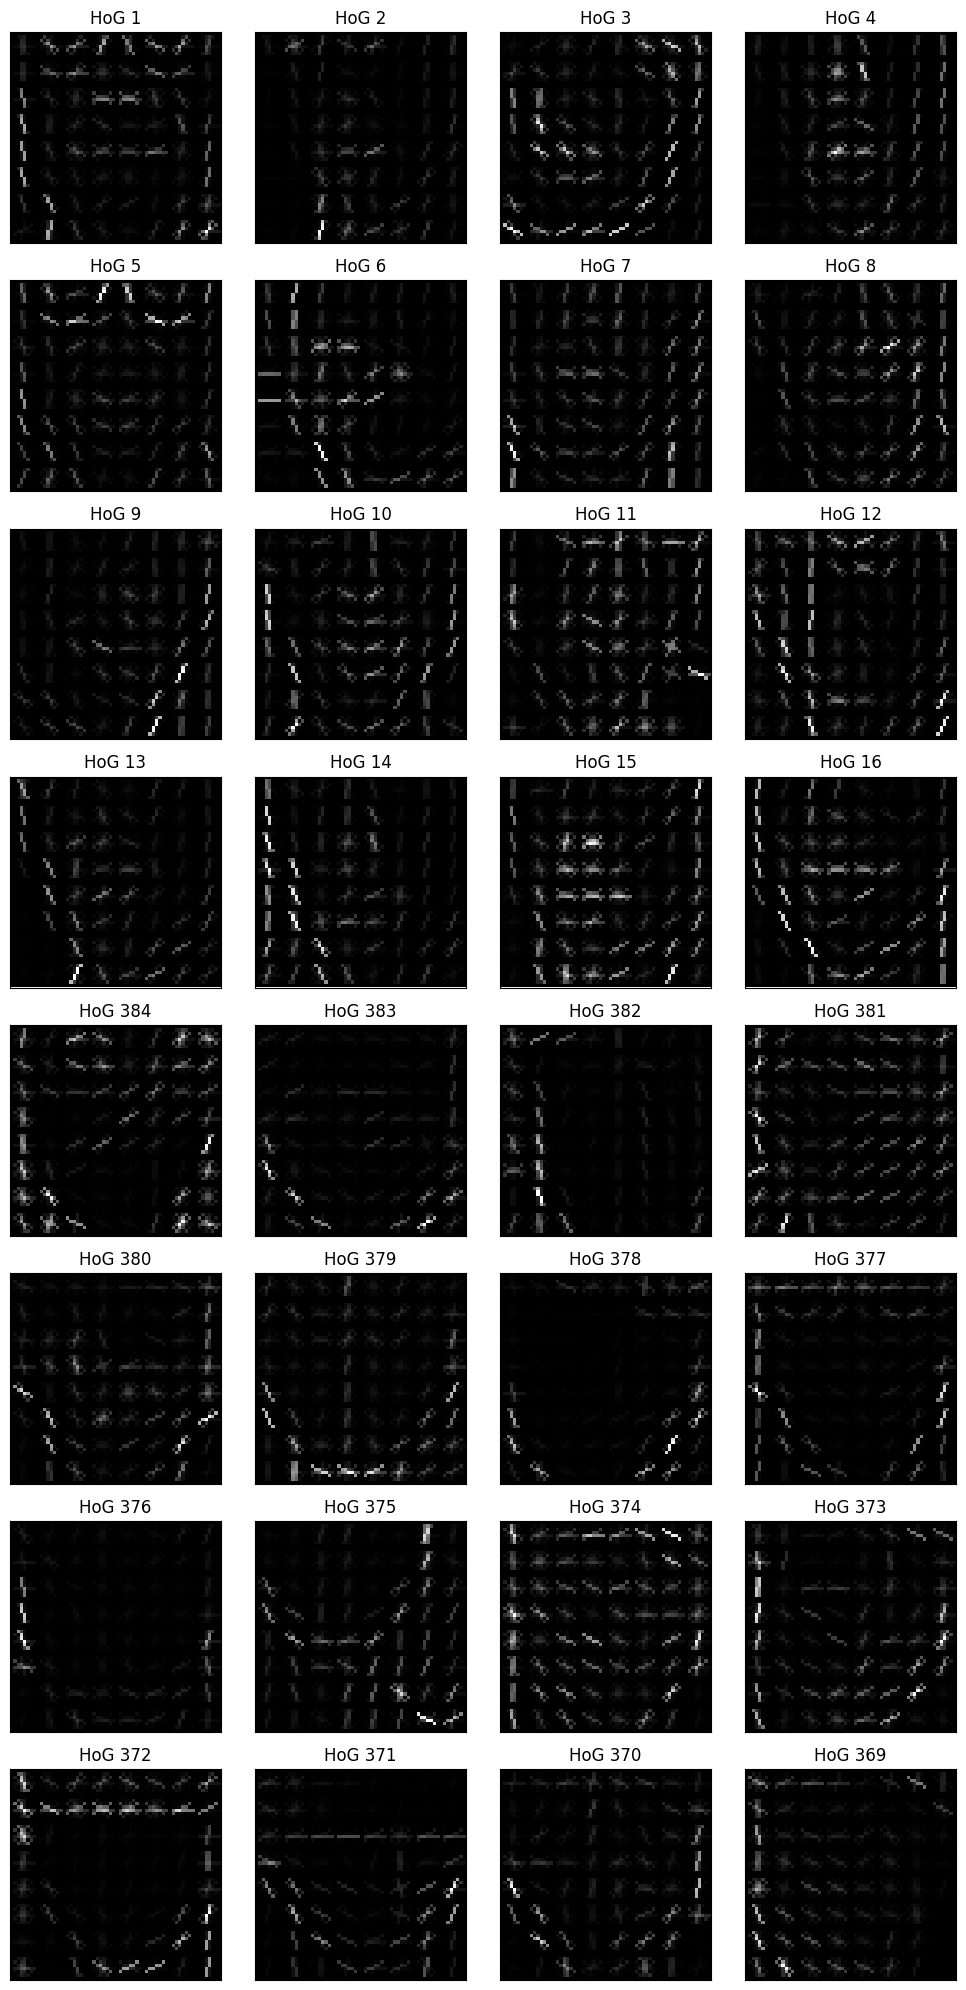

In [17]:
from skimage import exposure

ncol = 4
nrow = 8
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    if i < 16:
        temp =hog_img[i]
        hog_image = exposure.rescale_intensity(temp, in_range=(0, temp.max()))
        ax.imshow(hog_image, cmap='gray')
        ax.set_title(f'HoG {i+1}')
    else:
        temp =hog_img[len(hog_img) - (i)]
        hog_image = exposure.rescale_intensity(temp, in_range=(0, temp.max()))
        ax.imshow(hog_image, cmap='gray')
        ax.set_title(f'HoG {len(hog_img) - (i)}')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y )

# Training Process

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# 1. Scale fitur
# Scaling is crucial for SVM convergence and distance calculations
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 2. Setup Parameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# 3. Tuning & Training
# refit=True ensures the best model is retrained on the full X_train_s automatically
print("[INFO] Tuning hyperparameters and training...")
grid = GridSearchCV(
    SVC(probability=True, random_state=RANDOM_STATE),
    param_grid,
    refit=True,
    verbose=2,
    cv=5
)

grid.fit(X_train_s, y_train)

# Print best found parameters for your reference
print(f"[INFO] Best Parameters found: {grid.best_params_}")

# 4. Evaluasi
# grid.predict() automatically uses the best estimator found
y_pred = grid.predict(X_test_s)

print("\n[RESULT] Classification report:")
print(classification_report(y_test, y_pred, target_names=["without_mask", "with_mask"]))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

[INFO] Tuning hyperparameters and training...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.5s
[C

In [21]:
import joblib

MODEL_PATH = "svm_mask_hog_200.pkl"

# simpan model + scaler
joblib.dump({"model": grid.best_estimator_,
             "scaler": scaler,
             "config": {"image_size": IMAGE_SIZE,
                        "hog_params": {"orientations": ORIENTATIONS,
                                       "pixels_per_cell": PIXELS_PER_CELL,
                                       "cells_per_block": CELLS_PER_BLOCK},
                                        "crop": "bottom" }},
            MODEL_PATH)
print(f"[INFO] Model tersimpan di: {MODEL_PATH}")

[INFO] Model tersimpan di: svm_mask_hog_200.pkl


# Test Single Image

## 1. Face Detection

In [22]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [23]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
  )
    return faces

In [24]:
def crop_faces(image_gray, faces, return_all=False):
    cropped_faces = []
    selected_faces = []
    if len(faces) > 0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(image_gray[y:y+h, x:x+w])
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(image_gray[y:y+h, x:x+w])

    return cropped_faces, selected_faces

## 2. Feture Extraction

In [25]:
def feature_extraction_for_test(image_gray):

    features, hog_maps = [],[]

    faces = detect_faces(image_gray)

    cropped_face, _ = crop_faces(image_gray, faces)

    if cropped_face is None:
        print("wajah tidak terdeteksi..")
        return features, hog_maps
    else:

        img_crop = crop_half_image(cropped_face[0], bottom=True)

        # jika crop menghasilkan area kosong atau sangat kecil, fallback ke citra penuh
        if img_crop is None or img_crop.size == 0 or img_crop.shape[0] < 4 or img_crop.shape[1] < 4:
            img_crop = cropped_face[0]  # fallback
            # optional: print warning
            print(f"[WARN] Crop menghasilkan area kecil untuk {files}, menggunakan citra penuh.")

        roi_resized = cv2.resize(img_crop, IMAGE_SIZE, interpolation=cv2.INTER_AREA) # type: ignore

        features, hog_maps = extract_hog_features(roi_resized)
        features = np.array(features)
        features = features.reshape(1, -1)
        return features, hog_maps

## 3. Prediction Process

In [26]:
import joblib

def predict_image(image, features, model_path):

    data = joblib.load(model_path)
    model_loaded = data.get("model")
    scaler = data.get("scaler")

    if scaler is not None:
        features = scaler.transform(features)
    pred = model_loaded.predict(features)[0]
    conf = None
    prob = 0
    prob = model_loaded.predict_proba(features)[0] if hasattr(model_loaded, "predict_proba") else None
    conf = float(max(prob))

    if pred == 1:
        label_str = "MASK"
    else:
        label_str = "NO MASK"

    print(f"Prediksi: {label_str}")

    return draw_result(image, conf, label_str)

def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(10, 30),
              font_scale=0.6,
              font_thickness=2,
              text_color=(255, 255, 255),
              text_color_bg=(0, 0, 255)
              ):
    x, y = pos
    score_text = f'Score: {score:.2f}'

    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label,      font, font_scale, font_thickness)

    box_width  = max(w1, w2) + 20
    box_height = h1 + h2 + 25

    # pastikan tidak keluar dari gambar (opsional)
    x = max(0, x)
    y = max(box_height, y)

    # background kotak
    cv2.rectangle(image,
                  (x, y - box_height),
                  (x + box_width, y),
                  text_color_bg,
                  -1)

    # tulis label
    cv2.putText(image, label, (x + 10, y - h1 - 10),
                font, font_scale, text_color, font_thickness)

    # tulis score
    cv2.putText(image, score_text, (x + 10, y - 10),
                font, font_scale, text_color, font_thickness)


def draw_result(image_bgr, score, label):
    """
    image_bgr : citra BGR (OpenCV)
    score     : float
    label     : string
    return    : citra BGR yang sudah diberi teks
    """
    result_image = image_bgr.copy()
    draw_text(result_image, label, score, pos=(10, 40))
    return result_image


Prediksi: MASK


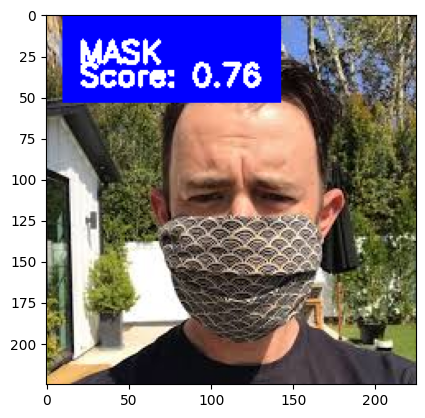

In [27]:
TESTING_IMAGE = "testing/mask2.jpeg"

hog_feature, hog_maps = [],[]
image_rgb, image_gray = load_image(TESTING_IMAGE)

hog_feature, hog_image = feature_extraction_for_test(image_gray)

result_image = predict_image(image_rgb, hog_feature, MODEL_PATH)

plt.imshow(result_image)


Prediksi: NO MASK


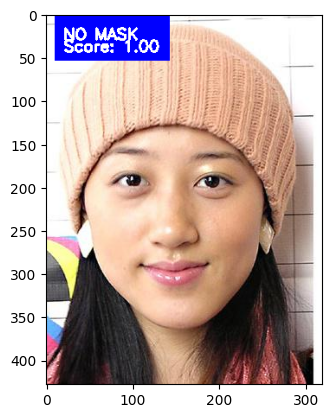

In [28]:
TESTING_IMAGE = "testing/1.jpg"

hog_feature, hog_maps = [],[]
image_rgb, image_gray = load_image(TESTING_IMAGE)

hog_feature, hog_maps = feature_extraction_for_test(image_gray)

result_image = predict_image(image_rgb, hog_feature, MODEL_PATH)

plt.imshow(result_image)
